In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [3]:
#Cart-pendulum problem
M = 3.0  # Cart mass
m = 1.0  # Pendulum mass
l = 1.0  # Pendulum length
g = 9.81  # Gravitational acceleration

# Target position
T = np.array([1.0, 0.5])

# Define the dynamics function
def dynamics(t, z, u):
    x, x_dot, phi, phi_dot = z
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)

    x_ddot_num = (m*g*sin_phi*cos_phi + m*l*phi_dot**2*sin_phi + u)
    x_ddot_den = (M + m*sin_phi**2)
    x_ddot = x_ddot_num/x_ddot_den
    phi_ddot = -g/l * sin_phi - (x_ddot_num/(l*x_ddot_den))*cos_phi
    return [x_dot, x_ddot, phi_dot, phi_ddot]

#define objective function for optimization
def objective_function(c):
    tf = 2.0
    t_span = (0, tf)
    u = np.poly1d(c)
    z0 = [0.0, 0.0, 0.0, 0.0]
    sol = solve_ivp(lambda t, z: dynamics(t, z, u(t)), t_span, z0, method='RK45')

    final_position = np.array([sol.y[0, -1] + l*np.sin(sol.y[2, -1]), -l * np.cos(sol.y[2, -1])])
    distance_to_target = np.linalg.norm(final_position - T)
    return distance_to_target


In [4]:
#Optimize for control
initial_guess = np.zeros(6)
result = minimize(objective_function, initial_guess, method='SLSQP')
optimized_coefficients = result.x
optimized_u = np.poly1d(optimized_coefficients)

In [9]:
#Calculate the dynamics
tf = 2.0
num_points = 5000
time_points = np.linspace(0, tf, num_points)
u_values = optimized_u(time_points)
num_integration_points = 200
sol_optimized = solve_ivp(lambda t, z: dynamics(t, z, optimized_u(t)), [0, tf], [0, 0, 0, 0], method='RK45', t_eval=np.linspace(0, tf, num_integration_points))

In [6]:
sol_optimized.y.shape

(4, 200)

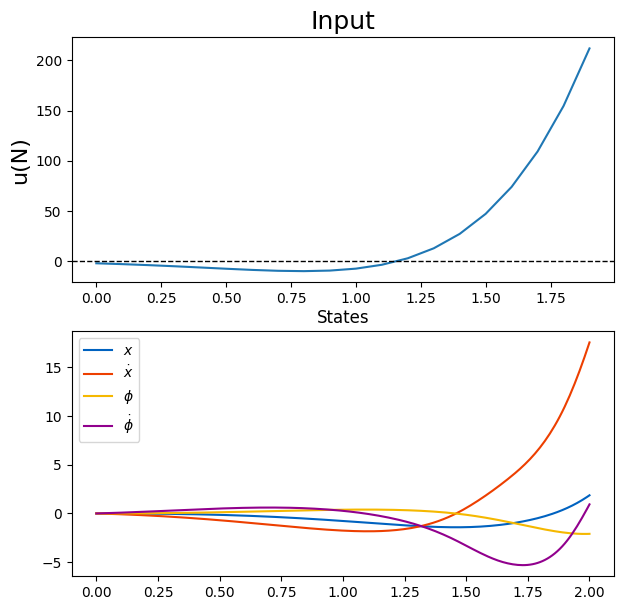

In [11]:
#Plot for dynamical state
t = np.arange(0, 2, 0.1)
fig, axes = plt.subplots(2, 1, figsize = (7, 7))

axes[0].plot(t, optimized_u(t))
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].set_ylabel('u(N)', fontsize = 16)
axes[0].set_title('Input', fontsize = 18)

axes[1].plot(sol_optimized.t, sol_optimized.y[0], label = '$x$', color = '#0062c0')
axes[1].plot(sol_optimized.t, sol_optimized.y[1], label = '$\\dot{x}$', color='#ed3f00')
axes[1].plot(sol_optimized.t, sol_optimized.y[2], label = '$\\phi$', color = '#f5b800')
axes[1].plot(sol_optimized.t, sol_optimized.y[3], label = '$\\dot{\\phi}$', color = '#91008d')
axes[1].set_title('States')

plt.legend()
plt.savefig('Input and var_first.jpg', dpi = 500)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

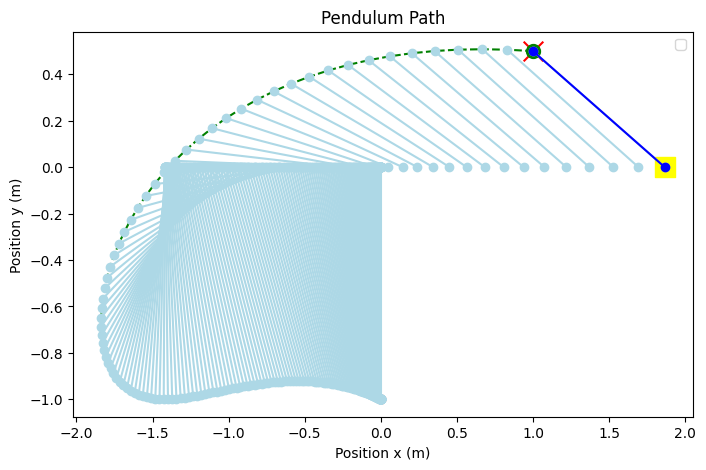

In [46]:
#plot for pendulum path
fig, ax = plt.subplots(figsize=(8,5))

car_x = sol_optimized.y[0]
car_y = np.zeros(len(car_x))
pendulum_path_x = sol_optimized.y[0] + l * np.sin(sol_optimized.y[2])
pendulum_path_y = -l * np.cos(sol_optimized.y[2])

x_value = [car_x[-1], pendulum_path_x[-1]]
y_value = [car_y[-1], pendulum_path_y[-1]]

x_values = [car_x, pendulum_path_x]
y_values = [car_y, pendulum_path_y]

ax.plot(pendulum_path_x, pendulum_path_y, linestyle = '--', color = 'green')
ax.scatter([1], [0.5], s = 200, marker='x', color = 'red')
ax.scatter(car_x[-1], car_y[-1], s=200, marker='s', color = 'yellow')
ax.scatter(pendulum_path_x[-1], pendulum_path_y[-1], s = 100, color = 'green')
ax.plot(x_values, y_values, marker='o', linestyle='-', color= 'lightblue')
ax.plot(x_value, y_value, marker='o', linestyle='-', color='blue')

plt.title('Pendulum Path')
plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')
plt.savefig('Pnedulam_path_first.jpg', dpi = 500)
plt.legend()
plt.show

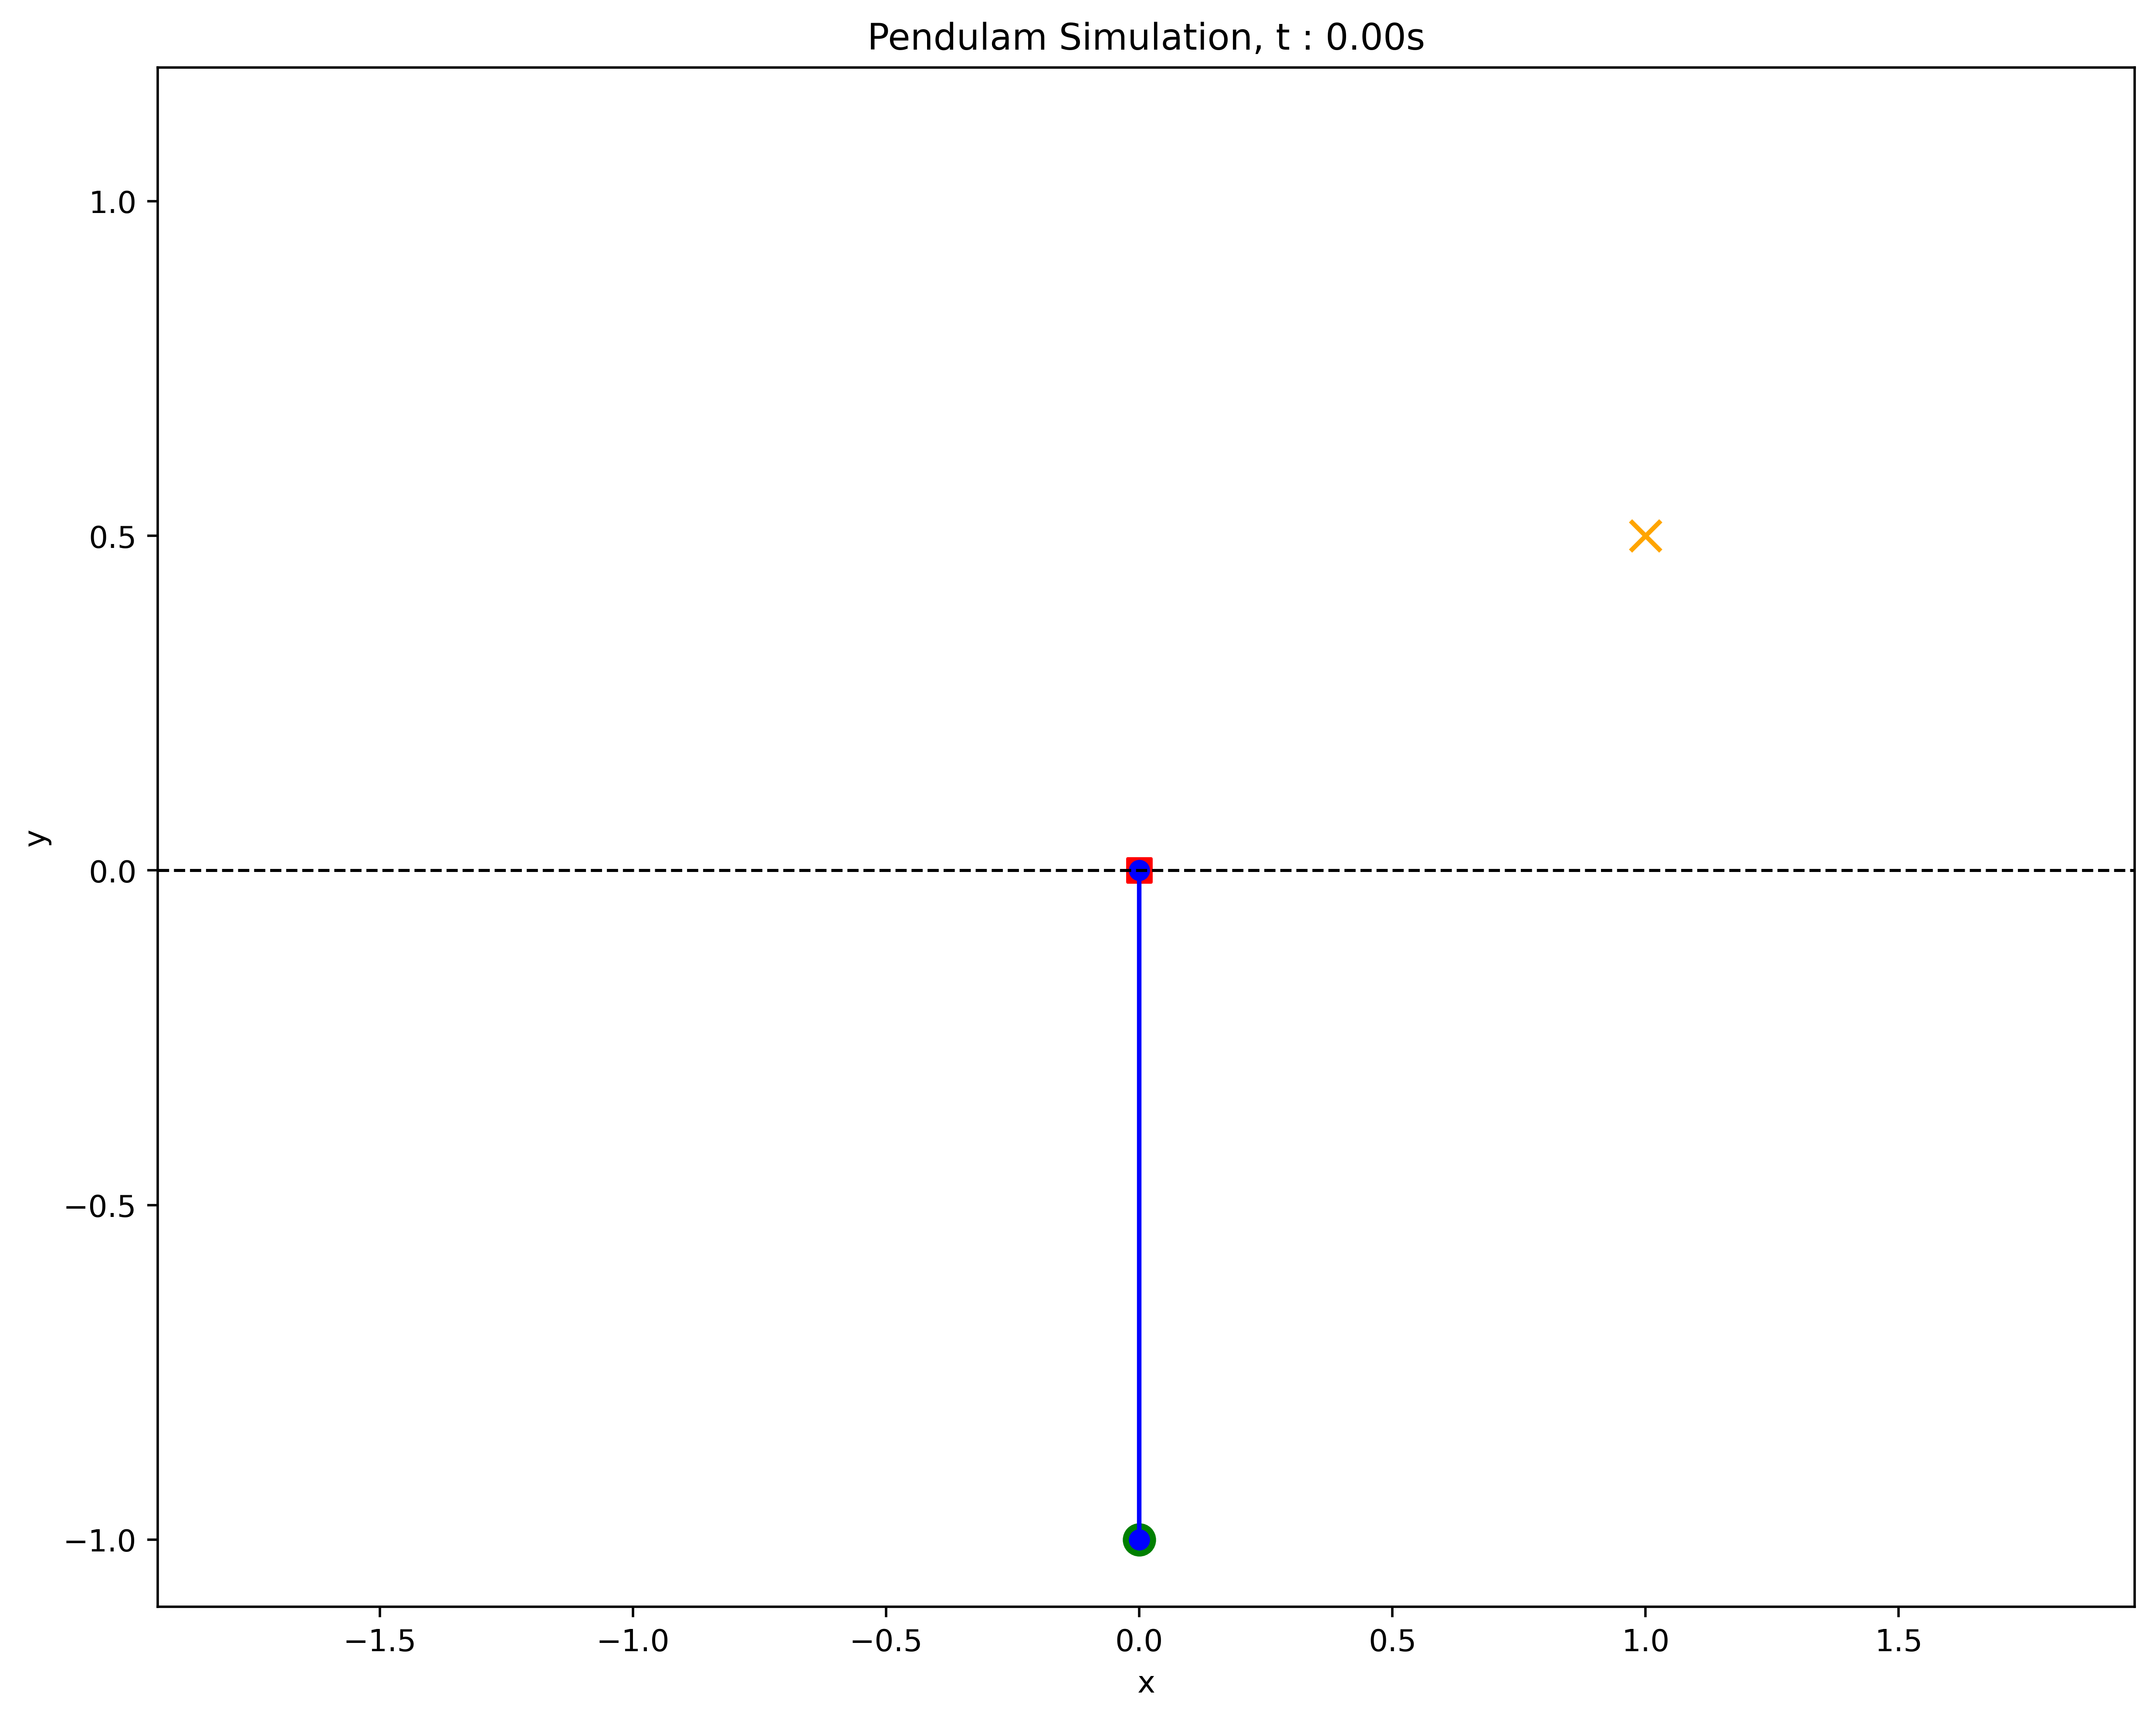

In [47]:
from matplotlib.animation import FuncAnimation

fps = 20
car_x = sol_optimized.y[0]
car_y = np.zeros(len(car_x))

pendulum_path_x = car_x + l * np.sin(sol_optimized.y[2])
pendulum_path_y = -l * np.cos(sol_optimized.y[2])

times = np.linspace(0, tf, num_integration_points)
def update(frame):

    if frame >= num_integration_points:
        frame = num_integration_points - 1

    plt.clf()
    ax = fig.add_subplot()


    x_values = [car_x[frame], pendulum_path_x[frame]]
    y_values = [car_y[frame], pendulum_path_y[frame]]

    ax.scatter(car_x[frame], car_y[frame], s=60, marker='s', color = 'red')
    ax.scatter(pendulum_path_x[frame], pendulum_path_y[frame], marker='o', s = 100, color = 'green')
    ax.plot(x_values, y_values, marker='o', linestyle='-', color='blue')
    ax.plot(pendulum_path_x[0:frame +1], pendulum_path_y[0:frame+1], linestyle='--', linewidth = 2, color='green')

    ax.scatter([1], [0.5], s = 100, marker='x', color = 'orange')
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim([min(car_x.min(), pendulum_path_x.min())-0.1, max(car_x.max(), pendulum_path_x.max())+0.1])
    ax.set_ylim([-1.1, 1.2])

    plt.title(f"Pendulam Simulation, t : {times[frame]:.2f}s")
    plt.tight_layout()

fig = plt.figure(figsize=(10, 8))
fig.set_dpi(500)
update(0)

animation = FuncAnimation(fig, update, frames=range(num_integration_points + fps*2), repeat=False, blit=False)
animation.save('Pendulum Simulation First.mp4', writer='ffmpeg', fps=fps, dpi = 500)